# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
from util import hidecode

from mpl_toolkits.mplot3d import Axes3D
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# # use MSE result as params_init
# params = {'step_size':1e-3, 
#           'max_iteration':5000, 
#           'random_restarts':1}

# # fit my neural network to minimize MSE on the given data
# my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

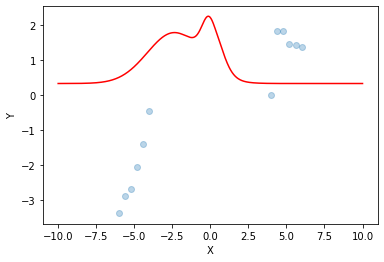

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

In [4]:
output_noise = 0.5**2
def log_likelihood(y_actual, y_pred):
    return -0.5 * np.log(2 * np.pi * output_noise) - 0.5 * np.mean(((y_actual - y_pred)**2).sum(axis = 1)) / output_noise

## random

In [5]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [6]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [7]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -117.64317843182843; gradient mag: 33.082620192107726
Iteration 200 lower bound -98.53447484127449; gradient mag: 8.841611834679311
Iteration 400 lower bound -95.18334931404696; gradient mag: 4.001006145865893
Iteration 600 lower bound -93.9932114724226; gradient mag: 2.5857896300407384
Iteration 800 lower bound -93.42962122414335; gradient mag: 1.643883230694722
Iteration 1000 lower bound -93.10151400722609; gradient mag: 1.014634512206945
Iteration 1200 lower bound -92.98439983140786; gradient mag: 0.7564436975891048
Iteration 1400 lower bound -92.89398012217498; gradient mag: 0.7529320169274091
Iteration 1600 lower bound -92.91923439850359; gradient mag: 0.29197875146397806
Iteration 1800 lower bound -92.84485163450779; gradient mag: 0.4731938839912986
Iteration 2000 lower bound -92.85317210064412; gradient mag: 0.6149042564609141
Iteration 2200 lower bound -92.84137021067963; gradient mag: 0.278423860645062
Iteration 2400 lower bound -92.86399831792636; grad

In [8]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.41 min


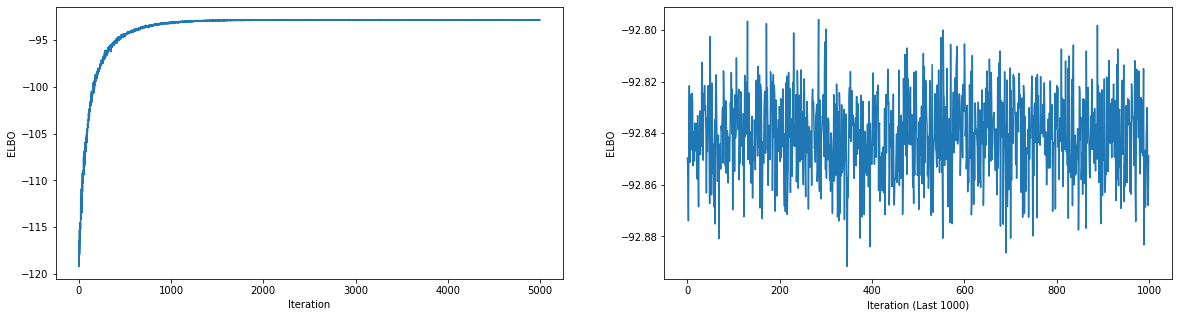

In [9]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-1000:])
ax[1].set_xlabel('Iteration (Last 1000)')
ax[1].set_ylabel('ELBO');

In [10]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

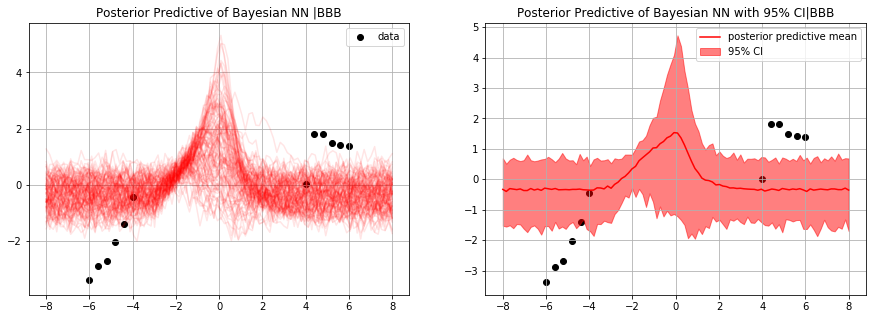

In [11]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

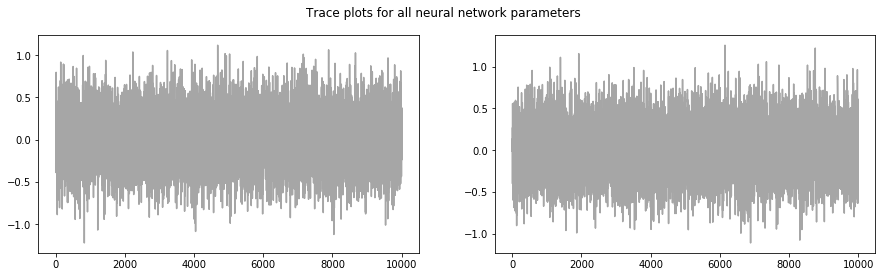

In [12]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [13]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -93.3310


posterior density

In [14]:
def plot_posterior_likelihood(my_inference,name,zx_range=[-0.2,0.2], zy_range=[-0.2,0.2]):
    zx=np.linspace(zx_range[0],zx_range[1],10)
    zy=np.linspace(zy_range[0],zy_range[1],10)
    zx,zy=np.meshgrid(zx,zy)
    z=np.array([zx,zy]).reshape(2,-1).T
    level = my_inference.get_posterior_likelihood(z=z,X=x,y=y).reshape(10,10)
    post_z=my_inference.get_posterior(50)
    post_level=my_inference.get_posterior_likelihood(z=post_z,X=x,y=y)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(zx,zy,level,cmap='Reds', edgecolor='none')
    ax.scatter3D(post_z[:,0],post_z[:,1],post_level,label='chosed posterior z')
    plt.title('posterior log density ',fontsize=15)
    ax.set_xlabel('z 1')
    ax.set_ylabel('z 2')
    ax.set_zlabel('posterior log density')
    plt.legend(loc='lower left')
    ax1= fig.add_subplot(122)
    cs=ax1.contourf(zx, zy, level, levels=20, linewidths=1,cmap='Reds')
    ax1.scatter(post_z[:,0],post_z[:,1],label='chosed posterior z',s=5)
    fig.colorbar(cs, ax=ax1)
    plt.xlabel('z 1')
    plt.ylabel('z 2')
    plt.title('posterior log density ',fontsize=15)
    plt.legend()
    plt.suptitle(name, fontsize=20)

## PCA

In [16]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [17]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [18]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=5)
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [19]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -1274382.8104450698; gradient mag: 742.3667810591551
Iteration 200 lower bound -1273630.4229015245; gradient mag: 742.1161452981352
Iteration 400 lower bound -1272894.8892311237; gradient mag: 741.7314004467041
Iteration 600 lower bound -1272123.7383095839; gradient mag: 741.4967856233006
Iteration 800 lower bound -1271402.9320402197; gradient mag: 741.2805063876283
Iteration 1000 lower bound -1270650.6104635969; gradient mag: 741.0496598298961
Iteration 1200 lower bound -1269910.9129769169; gradient mag: 740.8291888152905
Iteration 1400 lower bound -1269165.6365099617; gradient mag: 740.8443565192129
Iteration 1600 lower bound -1268438.6237184228; gradient mag: 740.405473714992
Iteration 1800 lower bound -1267695.372558154; gradient mag: 740.1794311292166
Iteration 2000 lower bound -1266946.333463818; gradient mag: 740.2152433874921
Iteration 2200 lower bound -1266211.9484491893; gradient mag: 739.7491727982089
Iteration 2400 lower bound -1265473.5273391139; gr

In [20]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 19.20 min


In [22]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

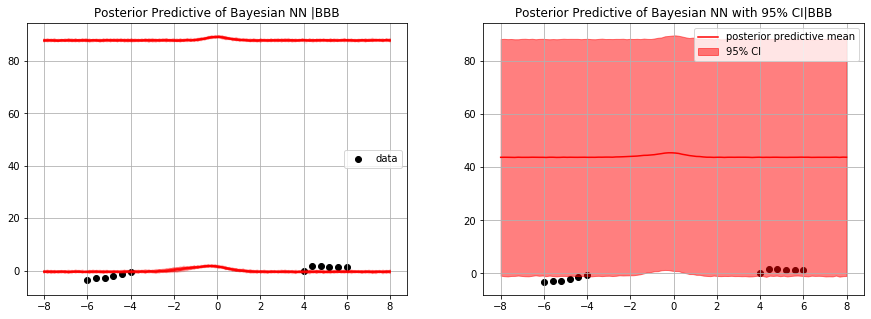

In [23]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

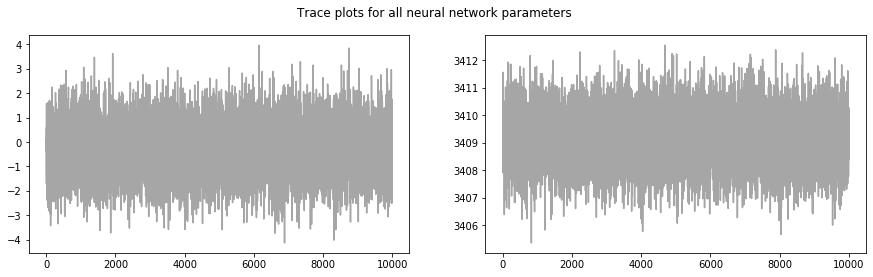

In [24]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [25]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca))

The Posterior Predictive Log likelihood of the observed data is -93682.2968
